### Demodulation - Compare Methods

## Import 

### Official Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime, read, Stream

from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Own Plotting Methods

In [4]:
import sys
sys.path.insert(0, 'submodules')

## Configurations

In [17]:
config = {}

config['path_to_data'] = archive_path+"romy_archive/"
config['path_to_tmp'] = archive_path+"temp_archive/"

config['tbeg'] = UTCDateTime("2024-07-11 15:00")
config['tend'] = UTCDateTime("2024-07-11 17:00")

### Load Data

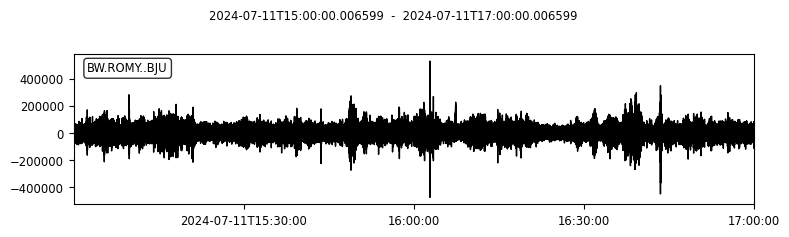

In [14]:
st_classic = __read_sds(config['path_to_data'], "BW.ROMY..BJU", config['tbeg'], config['tend'])

st_classic = st_classic.detrend("linear")

st_classic.plot();

### Load Processed Data

In [ ]:
# st_modifed = __read_sds(config['path_to_data'], "BW.ROMY.30.BJN", config['tbeg'], config['tend'])

# st_modifed = st_modifed.detrend("linear")

# st_modifed.plot();

### Load Sine Data

In [18]:
st_sine = __read_sds(config['path_to_tmp'], "BW.ROMY.60.BJU", config['tbeg'], config['tend'])

st_sine = st_sine.detrend("linear")

st_sine.plot();

IndexError: Empty stream object

### Load Hilbert2 Data

In [22]:
st_hilbert = __read_sds(config['path_to_tmp'], "BW.DROMY.80.FJU", config['tbeg'], config['tend'])

st_hilbert = st_hilbert.detrend("linear")

st_hilbert.plot();

IndexError: Empty stream object